In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt



psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3
number_of_layers = 2

psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()


# circuit
def build_experiment_circuit(delta, m):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        # controlled phase
        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])
        # unmatch
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # measure ancilla
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m - 1:
            qc.append(U_phi, phi_reg)

    return qc

In [5]:
def run_successful_shot(delta, m, max_trials=200):
    
    qc = build_experiment_circuit(delta, m)
    qc.save_statevector()
    sim = AerSimulator(method="statevector")
    tqc = transpile(qc, sim)

    zero_state = "0" * n

    for trial in range(max_trials):
        result = sim.run(tqc, shots=1, memory=True).result()
        mem = result.get_memory(tqc)[0]
        parts = mem.split(" ")
        if all(p == zero_state for p in parts):
            print(f"✅ Success for m={m} (trial {trial+1}) → {mem}")
            
            # Get the statevector from successful run
            full_state = result.get_statevector(tqc)
            
            # Partial trace to ψ subsystem
            rho_psi = partial_trace(full_state, list(range(n, 2*n)))
            
            # Ideal ψ state
            psi_vec = np.array(psi) / np.linalg.norm(psi)
            phi_vec = np.array(phi) / np.linalg.norm(phi)
            phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
            ideal_vec = psi_vec * phase_profile
            rho_ideal = DensityMatrix(ideal_vec)
            
            fid = state_fidelity(rho_psi, rho_ideal)
            print(f"Fidelity: {fid}")
            
            return True, full_state, fid
            
    print(f"❌ No success for m={m} after {max_trials} trials.")
    return False, None, None


Processing δ=0.314159
✅ Success for m=1 (trial 1) → 000
Fidelity: 0.9999921613718901
  Fidelity for m=1: 1.0000
✅ Success for m=2 (trial 1) → 000 000
Fidelity: 0.9999685768865921
  Fidelity for m=2: 1.0000
✅ Success for m=3 (trial 1) → 000 000 000
Fidelity: 0.9999291444734333
  Fidelity for m=3: 0.9999
✅ Success for m=4 (trial 1) → 000 000 000 000
Fidelity: 0.9998737631966685
  Fidelity for m=4: 0.9999
✅ Success for m=5 (trial 1) → 000 000 000 000 000
Fidelity: 0.9998023332895727
  Fidelity for m=5: 0.9998
✅ Success for m=6 (trial 1) → 000 000 000 000 000 000
Fidelity: 0.9997147561886063
  Fidelity for m=6: 0.9997
✅ Success for m=7 (trial 2) → 000 000 000 000 000 000 000
Fidelity: 0.9996109345676217
  Fidelity for m=7: 0.9996
✅ Success for m=8 (trial 1) → 000 000 000 000 000 000 000 000
Fidelity: 0.9994907723720811
  Fidelity for m=8: 0.9995
✅ Success for m=9 (trial 1) → 000 000 000 000 000 000 000 000 000
Fidelity: 0.9993541748533203
  Fidelity for m=9: 0.9994
✅ Success for m=10 (tri

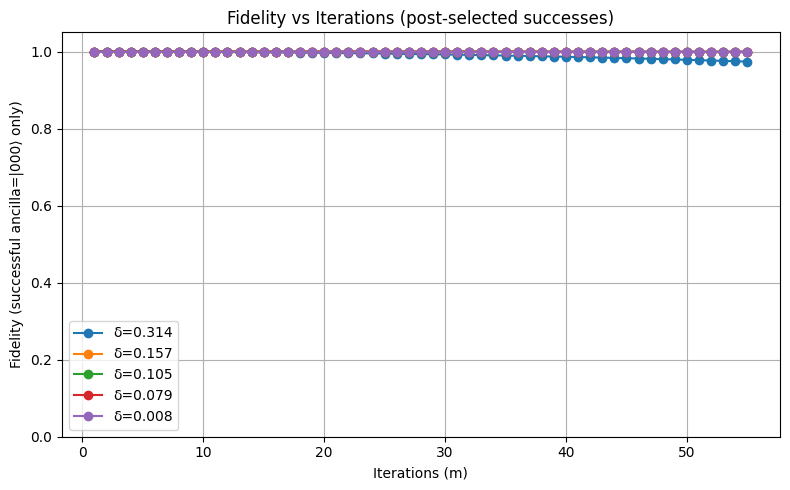

In [7]:
def fidelity_vs_iterations_success_only(delta, max_m, max_trials=200):
    fidelities = []
    for m in range(1, max_m+1):
        success, full_state, fid = run_successful_shot(delta, m, max_trials=max_trials)
        if success:
            print(f"  Fidelity for m={m}: {fid:.4f}")
            fidelities.append(fid)
        else:
            fidelities.append(np.nan)
    return fidelities


def plot_fidelity_vs_iterations(delta_values, max_m, max_trials=200):
    plt.figure(figsize=(8,5))
    for delta in delta_values:
        print(f"\nProcessing δ={delta:.6f}")
        fidelities = fidelity_vs_iterations_success_only(delta, max_m, max_trials=max_trials)
        m_values = np.arange(1, max_m+1)
        plt.plot(m_values, fidelities, "o-", label=f"δ={delta:.3f}")
    plt.xlabel("Iterations (m)")
    plt.ylabel("Fidelity (successful ancilla=|000⟩ only)")
    plt.title("Fidelity vs Iterations (post-selected successes)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


# Run the plot
delta_values = [np.pi/10, np.pi/20, np.pi/30, np.pi/40, np.pi/400]
plot_fidelity_vs_iterations(delta_values, max_m=55, max_trials=200)


Processing δ=0.314159
✅ Success 1/5 for m=1 (trial 1)
✅ Success 2/5 for m=1 (trial 2)
✅ Success 3/5 for m=1 (trial 3)
✅ Success 4/5 for m=1 (trial 4)
✅ Success 5/5 for m=1 (trial 5)
🎉 All 5 consecutive successes achieved!
Fidelity: 1.0000
  Fidelity for m=1: 1.0000
✅ Success 1/5 for m=2 (trial 1)
✅ Success 2/5 for m=2 (trial 2)
✅ Success 3/5 for m=2 (trial 3)
✅ Success 4/5 for m=2 (trial 4)
✅ Success 5/5 for m=2 (trial 5)
🎉 All 5 consecutive successes achieved!
Fidelity: 1.0000
  Fidelity for m=2: 1.0000
✅ Success 1/5 for m=3 (trial 1)
✅ Success 2/5 for m=3 (trial 2)
✅ Success 3/5 for m=3 (trial 3)
✅ Success 4/5 for m=3 (trial 4)
✅ Success 5/5 for m=3 (trial 5)
🎉 All 5 consecutive successes achieved!
Fidelity: 0.9999
  Fidelity for m=3: 0.9999
✅ Success 1/5 for m=4 (trial 2)
✅ Success 2/5 for m=4 (trial 3)
✅ Success 3/5 for m=4 (trial 4)
✅ Success 4/5 for m=4 (trial 5)
✅ Success 5/5 for m=4 (trial 6)
🎉 All 5 consecutive successes achieved!
Fidelity: 0.9999
  Fidelity for m=4: 0.9999
✅

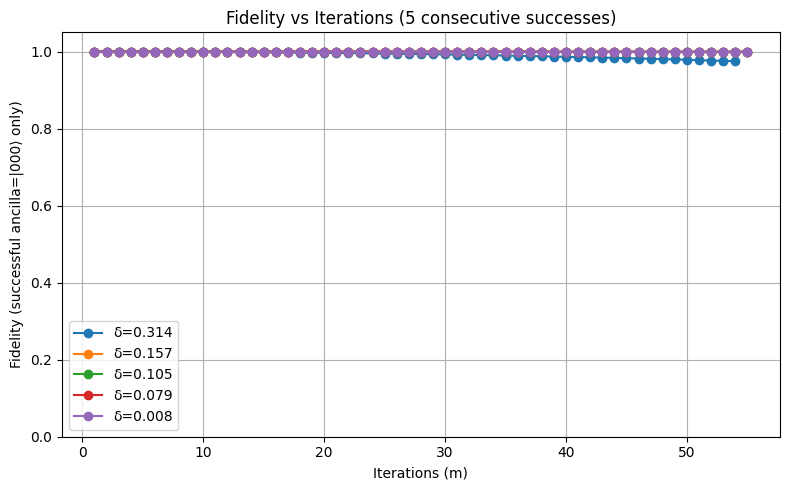

In [11]:
def build_experiment_circuit(delta, m):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])

        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m - 1:
            qc.append(U_phi, phi_reg)

    # Save statevector AFTER all measurements with label "sv"
    qc.save_statevector(label="sv")
    
    return qc


def run_successful_shot(delta, m, max_trials=200, required_successes=5):
    sim = AerSimulator(method='statevector')  # Explicitly use statevector method
    qc = build_experiment_circuit(delta, m)
    tqc = transpile(qc, sim)

    zero_state = "0" * n
    consecutive_successes = 0

    for trial in range(max_trials):
        result = sim.run(tqc, shots=1, memory=True).result()
        mem = result.get_memory(tqc)[0]
        parts = mem.split(" ")
        
        if all(p == zero_state for p in parts):
            consecutive_successes += 1
            print(f"✅ Success {consecutive_successes}/{required_successes} for m={m} (trial {trial+1})")
            
            if consecutive_successes == required_successes:
                # All consecutive successes achieved
                full_state = result.data()["sv"]
                print(f"🎉 All {required_successes} consecutive successes achieved!")
                
                # Calculate fidelity
                rho_psi = partial_trace(full_state, list(range(n, 2*n)))
                
                # Ideal ψ state
                psi_vec = np.array(psi) / np.linalg.norm(psi)
                phi_vec = np.array(phi) / np.linalg.norm(phi)
                phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
                ideal_vec = psi_vec * phase_profile
                rho_ideal = DensityMatrix(ideal_vec)
                
                fid = state_fidelity(rho_psi, rho_ideal)
                print(f"Fidelity: {fid:.4f}")
                
                return True, full_state, fid
        else:
            # Reset counter if we get a failure
            if consecutive_successes > 0:
                print(f"❌ Failed after {consecutive_successes} successes, resetting counter")
            consecutive_successes = 0

    print(f"❌ No {required_successes} consecutive successes for m={m} after {max_trials} trials.")
    return False, None, None


def fidelity_vs_iterations_success_only(delta, max_m, max_trials=200, required_successes=5):
    fidelities = []
    for m in range(1, max_m+1):
        success, full_state, fid = run_successful_shot(delta, m, max_trials=max_trials, required_successes=required_successes)
        if success:
            print(f"  Fidelity for m={m}: {fid:.4f}")
            fidelities.append(fid)
        else:
            fidelities.append(np.nan)
    return fidelities


def plot_fidelity_vs_iterations(delta_values, max_m, max_trials=200, required_successes=5):
    plt.figure(figsize=(8,5))
    for delta in delta_values:
        print(f"\nProcessing δ={delta:.6f}")
        fidelities = fidelity_vs_iterations_success_only(delta, max_m, max_trials=max_trials, required_successes=required_successes)
        m_values = np.arange(1, max_m+1)
        plt.plot(m_values, fidelities, "o-", label=f"δ={delta:.3f}")
    plt.xlabel("Iterations (m)")
    plt.ylabel("Fidelity (successful ancilla=|000⟩ only)")
    plt.title("Fidelity vs Iterations (5 consecutive successes)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


# Run the plot
delta_values = [np.pi/10, np.pi/20, np.pi/30, np.pi/40, np.pi/400]
plot_fidelity_vs_iterations(delta_values, max_m=55, max_trials=200, required_successes=5)